In [44]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

In [45]:
# Load packages
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.cluster import KMeans
import pickle
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [46]:
FILE_PATH = '../data/raw/survey_results_public.csv'
LOAD_PATH = '../data/interim/'
LOAD_SKILLS_DEV = '4.1-preprocessed-data_skills_dev.pkl'
LOAD_HEAT_MAP = '5.0-EDA-heat_map.pkl'
SAVE_SKILLS_DEV = '6.0-Engineered_data-split_roles-cluster_skills.pkl'
SAVE_CLUSTERED_skills  =  '6.0-clustered_skills.pkl'

## Helper Function

In [47]:
def reduce_dimensions(df):
    """Apply Tsne on the data frame for visualization & clustering purposes"""

    tsne_data = pd.DataFrame(TSNE(n_components=2,
                                  learning_rate=.01,
                                  perplexity=5,
                                  n_iter = 10**10,
                                  n_iter_without_progress = 3000,
                                  random_state=0)
                             .fit_transform(df),
                 index = df.index)

    return tsne_data

In [48]:
def evaluate_cluster_model(tsne_data, eps=3.5, min_samples=3):
    """using silhouette_score to chose the best number of clusters to cluster with using Kmeans clusters

    @param tsne_data: Dataframe result of TSNE algorithm
    @param range_clusters: The range of clusters you need to chose between them
    @param plot: Specify wither you need to plot silhouette_score values with clusters range and also plot Elbow Method or not

    @return: the best cluster number, and results of clustering
    """


    best_labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(tsne_data)
    best_labels = np.array([f'cluster_{label}' for label in best_labels])


    return best_labels

In [49]:
def visualize_chosen_cluster_model(role_type, tsne_data, cluster_labels):
    fig = px.scatter(x=tsne_data[0],
                    y=tsne_data[1],
                    text=tsne_data.index,
                    color=cluster_labels,
                     color_discrete_sequence=px.colors.qualitative.Dark24)
    fig.update_traces(textposition='top center')
    fig.update_layout(height=900, width=1500, title_text=f'Clustering top skills for {role_type}')
    fig.show()

# More preprocessing steps:
### 1. Drop roles: ['Student', 'Engineering manager', 'Other (please specify):', 'Project manager', 'Designer', 'Educator', 'Product manager', 'Marketing or sales professional']
### 2. split roles: ['Developer_full-stack', 'Developer_back-end']
### 3. Cluster similar roles

# Load Data

In [50]:
skills_dev_df = pd.read_pickle(LOAD_PATH + LOAD_SKILLS_DEV)
developers_skills = pd.read_pickle(LOAD_PATH + LOAD_HEAT_MAP)

# 1. Drop roles:
 1. 'Student',
 2. 'Engineering manager',
 3. 'Other (please specify):',
 4. 'Project manager',
 5. 'Designer',
 6. 'Educator',
 7. 'Product manager',
 8. 'Marketing or sales professional']

In [51]:
drop_roles = ['Student',
 'Engineering manager',
 'Other (please specify):',
 'Project manager',
 'Designer',
 'Educator',
 'Product manager',
 'Marketing or sales professional']

In [52]:
skills_dev_df = skills_dev_df.drop(drop_roles, axis = 1, level=1)

In [53]:
developers_skills = developers_skills.drop(drop_roles)

# 2. split roles: ['Developer_full-stack', 'Developer_back-end']

In [54]:
split_roles = ['Developer_full-stack', 'Developer_back-end']

In [55]:
def choose_most_related_skills(roles_type:list=None, exclude_roles:list = None, threshold:float = .5) ->pd.DataFrame:
    """For splitting roles we need to choose the most related skills with this role to cluster them and by using this we can split roles successfully

    @param roles_type: roles you need to choose the most related skills for them
    @param exclude_roles: roles you need to exclude to make sure that, skills results are related with our roles types not any other roles
    @param threshold: specify thresholding --percent from the mean of skills-- of sorted skills, choose only skills that have value more than the percent of skills mean

    @return: Most related skills for specific roles"""
    if roles_type is None:
        roles_type = ['Developer_full-stack']

    # Create mask for chosen roles
    role_mask = skills_dev_df['DevType'][roles_type].sum(axis = 1) == len(roles_type)
    if exclude_roles:
        role_mask =  role_mask & (skills_dev_df['DevType'][exclude_roles].sum(axis = 1) == 0)

    # applying mask on skills_dev_df and calculate the mean of these skills
    role_skills = skills_dev_df.loc[role_mask,: ].drop('DevType', axis = 1, level = 0).droplevel(axis = 1, level = 0)
    mean_role_skills = role_skills.mean() * 100
    # sorting skills
    most_related_role_skills = mean_role_skills.sort_values(ascending=False)
    # choosing the most related skills, skills that have values higher than percent --threshold-- from the mean of all skills
    most_related_role_skills = most_related_role_skills[most_related_role_skills > threshold * most_related_role_skills.mean()].index

    # Choose these skills from the masking dataframe and return them
    role_skills = role_skills.T
    role_skills = role_skills.loc[most_related_role_skills,:]

    return  role_skills

## A) Developer_full-stack

In [56]:
full_stack_skills = choose_most_related_skills(roles_type = [split_roles[0]], exclude_roles=['Developer_mobile'], threshold=.6)
full_stack_tsne = reduce_dimensions(full_stack_skills)
best_labels_full_stack = evaluate_cluster_model(full_stack_tsne)
visualize_chosen_cluster_model(split_roles[0], full_stack_tsne, best_labels_full_stack)

In [57]:
for label in sorted(set(best_labels_full_stack)):
    print(label, list(full_stack_tsne[best_labels_full_stack==label].index))


cluster_-1 ['Docker', 'React.js', 'PostgreSQL', 'Node.js', 'AWS', 'Python', 'Redis', 'Notepad++', 'Microsoft Azure', 'jQuery', 'SQLite', 'Google Cloud', 'Go', 'Elasticsearch', 'DigitalOcean', 'Firebase', 'C++', 'Webstorm', 'Oracle', 'Eclipse', 'C']
cluster_0 ['JavaScript', 'Visual Studio Code', 'HTML/CSS', 'npm', 'SQL', 'TypeScript']
cluster_1 ['C#', 'Visual Studio', 'Microsoft SQL Server', '.NET', 'ASP.NET Core ', 'ASP.NET']
cluster_2 ['Java', 'IntelliJ', 'Spring']
cluster_3 ['MongoDB', 'Yarn', 'Express', 'Next.js']
cluster_4 ['MySQL', 'Vue.js', 'PHP', 'MariaDB', 'Laravel', 'PhpStorm']
cluster_5 ['Bash/Shell', 'Vim', 'Rust']
cluster_6 ['Kubernetes', 'Android Studio', 'Terraform', 'React Native', 'DynamoDB', 'Kotlin', 'Flutter', 'Apache Kafka']
cluster_7 ['PyCharm', 'NumPy', 'Django', 'Pandas', 'Flask']
cluster_8 ['Angular', 'Sublime Text', 'PowerShell', 'Angular.js']
cluster_9 ['Homebrew', 'Heroku', 'Ruby']


In [58]:
# filtering skills results
full_stack_roles_skills = []
for label in sorted(set(best_labels_full_stack)):
    # these clusters numbers are not specific for any full_stack developer, but it's general skills
    if label in  [f'cluster_{i}' for i in [-1, 0, 5, 6, 8, 9]]:
        continue

    cluster_labels = list(full_stack_tsne[best_labels_full_stack==label].index)
    if label == 'cluster_3':
        # [cluster_labels.remove(item) for item in ['JavaScript', 'Visual Studio Code', 'HTML/CSS', 'npm', 'SQL', 'TypeScript']]
        cluster_labels += ['React.js', 'Node.js']

    if label == 'cluster_7':
        cluster_labels += ['Python']

    if label == 'cluster_4':
        cluster_labels +=['jQuery']

    if label == 'cluster_1':
        cluster_labels +=['Microsoft Azure']

    full_stack_roles_skills.append(cluster_labels)
full_stack_roles_skills

[['C#',
  'Visual Studio',
  'Microsoft SQL Server',
  '.NET',
  'ASP.NET Core ',
  'ASP.NET',
  'Microsoft Azure'],
 ['Java', 'IntelliJ', 'Spring'],
 ['MongoDB', 'Yarn', 'Express', 'Next.js', 'React.js', 'Node.js'],
 ['MySQL', 'Vue.js', 'PHP', 'MariaDB', 'Laravel', 'PhpStorm', 'jQuery'],
 ['PyCharm', 'NumPy', 'Django', 'Pandas', 'Flask', 'Python']]

In [59]:
full_stack_types = ['full_stack_.NET', 'full_stack_Java', 'full_stack_.JavaScript', 'full_stack_PHP', 'full_stack_python']

In [60]:
is_full_stack = skills_dev_df['DevType']['Developer_full-stack'] == 1
print(is_full_stack.sum())
full_stack_roles = {}
for i, cluster_labels in enumerate(full_stack_roles_skills):

    total_skills = skills_dev_df.droplevel(level=0, axis = 1)[cluster_labels].sum(axis=1)

    # assign true for this specific type if this developer has summation skills more than the mean
    is_full_stack_specific_type = total_skills > total_skills.mean()
    print(f'cluster_{i}: ', (is_full_stack & is_full_stack_specific_type).sum())
    full_stack_roles[full_stack_types[i]] = is_full_stack & is_full_stack_specific_type

20928
cluster_0:  7816
cluster_1:  8158
cluster_2:  11917
cluster_3:  11070
cluster_4:  6991


## Good results

In [61]:
full_stack_roles_df = pd.concat(full_stack_roles, axis = 1)
full_stack_roles_df = pd.concat([full_stack_roles_df,is_full_stack], axis = 1)
full_stack_roles_df


,full_stack_.NET,full_stack_Java,full_stack_.JavaScript,full_stack_PHP,full_stack_python,Developer_full-stack
2,False,False,False,False,False,False
3,True,False,False,False,False,True
7,False,True,True,True,False,True
9,False,False,False,False,False,False
10,True,False,False,False,False,True
...,...,...,...,...,...,...
73262,False,False,False,False,False,False
73263,False,False,False,False,False,False
73264,False,False,False,False,False,False
73265,True,False,False,True,True,True


In [62]:
# count number of roles that is full stack, but not have any specific type
(full_stack_roles_df.iloc[full_stack_roles_df['Developer_full-stack'].values,:-1].sum(axis=1) == 0).sum()

797

In [63]:
full_stack_roles_df = full_stack_roles_df.rename(columns = {'Developer_full-stack': 'full-stack_general'})
full_stack_roles_df.columns = pd.MultiIndex.from_product([['DevType'], full_stack_roles_df.columns])
full_stack_roles_df = full_stack_roles_df.astype(int)
full_stack_roles_df

DevType                                                        \
      full_stack_.NET full_stack_Java full_stack_.JavaScript full_stack_PHP   
2                   0               0                      0              0   
3                   1               0                      0              0   
7                   0               1                      1              1   
9                   0               0                      0              0   
10                  1               0                      0              0   
...               ...             ...                    ...            ...   
73262               0               0                      0              0   
73263               0               0                      0              0   
73264               0               0                      0              0   
73265               1               0                      0              1   
73266               0               0                      0              0   

                                            
      full_stack_python full-stack_general  
2                     0                  0  
3                     0                  1  
7                     0                  1  
9                     0                  0  
10                    0                  1  
...                 ...                ...  
73262                 0                  0  
73263                 0                  0  
73264                 0                  0  
73265                 1                  1  
73266                 0                  0  

[50423 rows x 6 columns]

--------------------------

## B) Developer_back-end
Repeat the same steps

In [64]:
# Here we need to split back-end developer, by also excluding Front-end and mobile roles
back_end_skills = choose_most_related_skills(roles_type = [split_roles[1]], exclude_roles=['Developer_front-end', 'Developer_mobile'], threshold = .6)
back_end_tsne = reduce_dimensions(back_end_skills)
best_labels_back_end = evaluate_cluster_model(back_end_tsne)
visualize_chosen_cluster_model(split_roles[1], back_end_tsne, best_labels_back_end)

In [65]:
for label in sorted(set(best_labels_back_end)):
    print(label, list(back_end_tsne[best_labels_back_end==label].index))


cluster_-1 ['Redis', 'Bash/Shell', 'Elasticsearch', 'Rust', 'NumPy', 'Sublime Text', 'Pandas', 'DigitalOcean', 'Ansible', 'Neovim']
cluster_0 ['Visual Studio Code', 'Docker', 'PostgreSQL', 'AWS']
cluster_1 ['SQL', 'JavaScript', 'HTML/CSS']
cluster_10 ['Notepad++', 'Oracle', 'Eclipse']
cluster_11 ['Go', 'IPython/Jupyter', 'TensorFlow', 'GoLand', 'Nano']
cluster_2 ['IntelliJ', 'Java', 'Spring']
cluster_3 ['npm', 'TypeScript', 'MongoDB', 'Node.js', 'React.js', 'Yarn', 'Express']
cluster_4 ['C#', 'Visual Studio', 'Microsoft Azure', '.NET', 'Microsoft SQL Server', 'ASP.NET Core ', 'ASP.NET', 'PowerShell']
cluster_5 ['Vim', 'C++', 'C']
cluster_6 ['Python', 'SQLite', 'PyCharm', 'Django', 'Flask', 'FastAPI']
cluster_7 ['Homebrew', 'Google Cloud', 'Apache Kafka', 'Angular', 'Kotlin', 'Heroku', 'Android Studio', 'Ruby', 'Firebase']
cluster_8 ['Kubernetes', 'Terraform', 'DynamoDB']
cluster_9 ['MySQL', 'PHP', 'jQuery', 'MariaDB', 'Vue.js', 'PhpStorm', 'Laravel']


In [66]:
# Filtering cluster results
back_end_roles_skills = []
for label in sorted(set(best_labels_back_end)):
    # these clusters numbers are not specific for any full_stack developer, but it's general skills
    if label in  [f'cluster_{i}' for i in [-1, 0, 1, 10, 11, 7, 8]]:
        continue
    cluster_labels = list(back_end_tsne[best_labels_back_end==label].index)

    back_end_roles_skills.append(cluster_labels)
back_end_roles_skills

[['IntelliJ', 'Java', 'Spring'],
 ['npm', 'TypeScript', 'MongoDB', 'Node.js', 'React.js', 'Yarn', 'Express'],
 ['C#',
  'Visual Studio',
  'Microsoft Azure',
  '.NET',
  'Microsoft SQL Server',
  'ASP.NET Core ',
  'ASP.NET',
  'PowerShell'],
 ['Vim', 'C++', 'C'],
 ['Python', 'SQLite', 'PyCharm', 'Django', 'Flask', 'FastAPI'],
 ['MySQL', 'PHP', 'jQuery', 'MariaDB', 'Vue.js', 'PhpStorm', 'Laravel']]

In [67]:
back_end_types = ['back_end_Java', 'back_end_.JavaScript', 'back_end_.NET', 'back_end_C++', 'back_end_python', 'back_end_PHP']

In [68]:
is_back_end = skills_dev_df['DevType']['Developer_back-end'] == 1
print(is_back_end.sum())
back_end_roles = {}
for i, cluster_labels in enumerate(back_end_roles_skills):

    total_skills = skills_dev_df.droplevel(level=0, axis = 1)[cluster_labels].sum(axis=1)
    is_back_end_specific_type = total_skills > total_skills.mean()
    print(f'cluster_{i}: ', (is_back_end & is_back_end_specific_type).sum())
    back_end_roles[back_end_types[i]] = is_back_end & is_back_end_specific_type

18692
cluster_0:  8415
cluster_1:  8095
cluster_2:  5691
cluster_3:  7165
cluster_4:  8488
cluster_5:  8198


In [69]:
back_end_roles_df = pd.concat(back_end_roles, axis = 1)
back_end_roles_df = pd.concat([back_end_roles_df,is_back_end], axis = 1)
back_end_roles_df


,back_end_Java,back_end_.JavaScript,back_end_.NET,back_end_C++,back_end_python,back_end_PHP,Developer_back-end
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False
10,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...
73262,False,False,False,False,False,False,False
73263,False,True,False,True,True,True,True
73264,False,False,False,False,False,False,False
73265,False,False,False,False,False,False,False


In [70]:
(back_end_roles_df.iloc[back_end_roles_df['Developer_back-end'].values,:-1].sum(axis=1) ==0).sum()

603

In [71]:
back_end_roles_df = back_end_roles_df.rename(columns = {'Developer_back-end': 'back_end_general'})
back_end_roles_df.columns = pd.MultiIndex.from_product([['DevType'], back_end_roles_df.columns])
back_end_roles_df = back_end_roles_df.astype(int)
back_end_roles_df

DevType                                                  \
      back_end_Java back_end_.JavaScript back_end_.NET back_end_C++   
2                 0                    0             0            0   
3                 0                    0             0            0   
7                 0                    0             0            0   
9                 0                    0             0            0   
10                0                    0             1            0   
...             ...                  ...           ...          ...   
73262             0                    0             0            0   
73263             0                    1             0            1   
73264             0                    0             0            0   
73265             0                    0             0            0   
73266             0                    0             0            0   

                                                     
      back_end_python back_end_PHP back_end_general  
2                   0            0                0  
3                   0            0                0  
7                   0            0                0  
9                   0            0                0  
10                  0            0                1  
...               ...          ...              ...  
73262               0            0                0  
73263               1            1                1  
73264               0            0                0  
73265               0            0                0  
73266               0            0                0  

[50423 rows x 7 columns]

---------------------

# 3. Clustering similar skills

In [72]:
def kmeans_clustering(tsne_data, range_clusters, plot = True):
    wcss = []
    scores = []
    for k in range_clusters:
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init='auto', random_state=0)
        labels = kmeans.fit_predict(tsne_data)
        wcss.append(kmeans.inertia_)

        score = silhouette_score(tsne_data, labels)
        scores.append(score)

    best_k = np.argmax(scores) + range_clusters[0]
    best_labels = KMeans(n_clusters=best_k, init='k-means++', max_iter=1000, n_init='auto', random_state=0).fit_predict(tsne_data)
    best_labels = np.array([f'cluster_{label}' for label in best_labels])

    if plot:
        # silhouette score
        fig = px.line(x= range_clusters, y = scores)
        fig.add_vline(best_k)
        fig.update_layout(height=450, width=900, title='Silhouette Score')
        fig.show()

        # Plot the WCSS values\n",
        plt.plot(range_clusters, wcss)
        plt.title('Elbow Method')
        plt.xlabel('Number of clusters')
        plt.ylabel('WCSS')
        plt.show()

    return best_k, best_labels

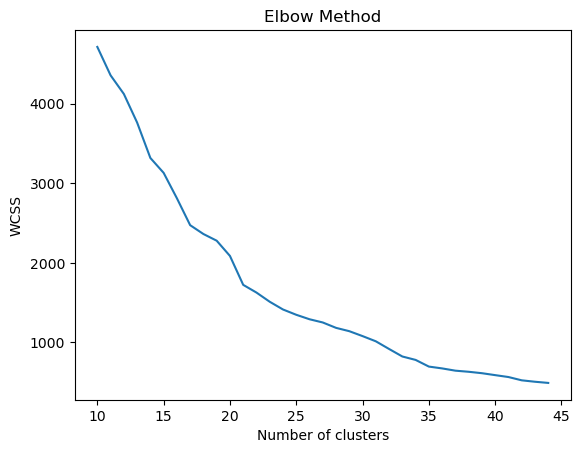

In [73]:
all_skills = skills_dev_df.drop('DevType', axis = 1, level = 0).droplevel(axis = 1, level = 0).T
all_skills_tsne = reduce_dimensions(all_skills)
best_k, best_labels_all_skills = kmeans_clustering(all_skills_tsne, range(10,45))
visualize_chosen_cluster_model('All roles', all_skills_tsne, best_labels_all_skills)

In [74]:
for label in sorted(set(best_labels_all_skills)):
    print(label, list(all_skills_tsne[best_labels_all_skills==label].index))

cluster_0 ['Cassandra', 'Elasticsearch', 'PostgreSQL', 'Redis']
cluster_1 ['PHP', 'MariaDB', 'MySQL', 'Laravel', 'Symfony', 'PhpStorm']
cluster_10 ['APL', 'COBOL', 'Crystal', 'SAS', 'Solidity', 'Couchbase', 'IBM DB2', 'Colocation', 'IBM Cloud or Watson', 'Managed Hosting', 'TextMate']
cluster_11 ['PowerShell', 'Oracle', 'Oracle Cloud Infrastructure', 'GTK', 'Uno Platform', 'Nano']
cluster_12 ['Angular', 'Capacitor', 'Cordova', 'Ionic']
cluster_13 ['Groovy', 'Java', 'Spring', 'IntelliJ']
cluster_14 ['Eclipse', 'NetBeans', 'Notepad++']
cluster_15 ['Rust', 'Deno', 'Nuxt.js', 'Svelte', 'Vue.js']
cluster_16 ['Objective-C', 'Swift', 'Homebrew', 'Xcode']
cluster_17 ['Scala', 'Play Framework', 'RubyMine']
cluster_18 ['Delphi', 'RAD Studio (Delphi_C++ Builder)']
cluster_19 ['Go', 'GoLand']
cluster_2 ['Perl', 'Qt', 'Qt Creator', 'Vim']
cluster_20 ['Elixir', 'Phoenix']
cluster_21 ['CouchDB', 'DigitalOcean', 'Heroku', 'Linode', 'OVH', 'VMware', 'Fastify', 'Electron']
cluster_22 ['Ruby', 'Ruby on R

### Adding new Features --clustering results--

In [75]:
skills_df = skills_dev_df.drop('DevType', axis=1, level = 0).droplevel(axis=1, level = 0)
clustered_skills_df = {}
for label in sorted(set(best_labels_all_skills)):
    if label == 'cluster_-1':
        continue
    clustered_skills = list(all_skills_tsne[best_labels_all_skills==label].index)
    # clustered_skills_df[label] = skills_df[clustered_skills].apply(lambda x : np.count_nonzero(np.array(x)), axis = 1)
    clustered_skills_df[label] = skills_df[clustered_skills].sum(axis = 1)

In [76]:
clustered_skills_df = pd.concat(clustered_skills_df, axis = 1)
clustered_skills_df

,cluster_0,cluster_1,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,...,cluster_31,cluster_32,cluster_33,cluster_34,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
2,0.00,0.0,0.00,0.0,0.25,0.00,0.75,0.00,0.0,0.0,...,1.75,0.0,0.0,1.0,0.00,0.00,0.0,0.00,2.50,0.0
3,0.00,0.0,0.00,0.0,0.00,0.00,1.50,0.00,0.0,0.0,...,4.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,10.50,0.0
7,0.50,1.0,0.50,0.0,0.50,2.00,2.00,0.50,0.0,0.0,...,4.00,0.0,0.0,0.5,2.00,0.50,0.0,0.50,2.50,0.5
9,0.00,0.0,0.00,0.0,0.00,1.50,0.00,0.00,3.0,0.0,...,1.50,0.0,0.0,0.0,0.00,1.50,0.0,0.00,0.00,0.0
10,0.00,0.0,0.00,1.0,0.00,0.00,0.00,1.00,0.0,0.0,...,5.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,11.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73262,0.00,0.0,0.00,0.0,0.00,0.75,0.50,0.00,0.0,0.0,...,1.75,0.0,0.0,0.0,0.00,0.25,0.0,0.00,0.00,0.0
73263,4.00,2.5,0.00,0.0,0.00,0.00,0.00,0.00,1.5,0.0,...,6.00,0.0,0.0,1.5,1.50,2.00,0.0,0.00,1.50,1.0
73264,1.50,0.0,0.00,1.0,0.00,0.00,1.50,0.00,0.0,0.0,...,4.50,0.0,0.0,4.5,0.50,0.00,0.0,0.00,1.00,8.0
73265,0.75,2.5,0.75,0.0,0.50,0.00,0.00,0.25,0.0,0.0,...,3.00,0.0,0.0,1.5,0.75,0.00,0.0,0.25,5.25,0.0


In [77]:
clustered_skills_df

,cluster_0,cluster_1,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,...,cluster_31,cluster_32,cluster_33,cluster_34,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
2,0.00,0.0,0.00,0.0,0.25,0.00,0.75,0.00,0.0,0.0,...,1.75,0.0,0.0,1.0,0.00,0.00,0.0,0.00,2.50,0.0
3,0.00,0.0,0.00,0.0,0.00,0.00,1.50,0.00,0.0,0.0,...,4.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,10.50,0.0
7,0.50,1.0,0.50,0.0,0.50,2.00,2.00,0.50,0.0,0.0,...,4.00,0.0,0.0,0.5,2.00,0.50,0.0,0.50,2.50,0.5
9,0.00,0.0,0.00,0.0,0.00,1.50,0.00,0.00,3.0,0.0,...,1.50,0.0,0.0,0.0,0.00,1.50,0.0,0.00,0.00,0.0
10,0.00,0.0,0.00,1.0,0.00,0.00,0.00,1.00,0.0,0.0,...,5.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,11.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73262,0.00,0.0,0.00,0.0,0.00,0.75,0.50,0.00,0.0,0.0,...,1.75,0.0,0.0,0.0,0.00,0.25,0.0,0.00,0.00,0.0
73263,4.00,2.5,0.00,0.0,0.00,0.00,0.00,0.00,1.5,0.0,...,6.00,0.0,0.0,1.5,1.50,2.00,0.0,0.00,1.50,1.0
73264,1.50,0.0,0.00,1.0,0.00,0.00,1.50,0.00,0.0,0.0,...,4.50,0.0,0.0,4.5,0.50,0.00,0.0,0.00,1.00,8.0
73265,0.75,2.5,0.75,0.0,0.50,0.00,0.00,0.25,0.0,0.0,...,3.00,0.0,0.0,1.5,0.75,0.00,0.0,0.25,5.25,0.0


In [78]:
clustered_skills_df.columns = pd.MultiIndex.from_product([['clustered_skills'], clustered_skills_df.columns])

In [79]:
clustered_skills_df

clustered_skills                                                        \
             cluster_0 cluster_1 cluster_10 cluster_11 cluster_12 cluster_13   
2                 0.00       0.0       0.00        0.0       0.25       0.00   
3                 0.00       0.0       0.00        0.0       0.00       0.00   
7                 0.50       1.0       0.50        0.0       0.50       2.00   
9                 0.00       0.0       0.00        0.0       0.00       1.50   
10                0.00       0.0       0.00        1.0       0.00       0.00   
...                ...       ...        ...        ...        ...        ...   
73262             0.00       0.0       0.00        0.0       0.00       0.75   
73263             4.00       2.5       0.00        0.0       0.00       0.00   
73264             1.50       0.0       0.00        1.0       0.00       0.00   
73265             0.75       2.5       0.75        0.0       0.50       0.00   
73266             0.00       0.0       0.00        1.0       0.00       0.00   

                                                   ...                        \
      cluster_14 cluster_15 cluster_16 cluster_17  ... cluster_31 cluster_32   
2           0.75       0.00        0.0        0.0  ...       1.75        0.0   
3           1.50       0.00        0.0        0.0  ...       4.00        0.0   
7           2.00       0.50        0.0        0.0  ...       4.00        0.0   
9           0.00       0.00        3.0        0.0  ...       1.50        0.0   
10          0.00       1.00        0.0        0.0  ...       5.00        0.0   
...          ...        ...        ...        ...  ...        ...        ...   
73262       0.50       0.00        0.0        0.0  ...       1.75        0.0   
73263       0.00       0.00        1.5        0.0  ...       6.00        0.0   
73264       1.50       0.00        0.0        0.0  ...       4.50        0.0   
73265       0.00       0.25        0.0        0.0  ...       3.00        0.0   
73266       0.00       0.00        0.0        0.0  ...       0.00        0.0   

                                                                               \
      cluster_33 cluster_34 cluster_4 cluster_5 cluster_6 cluster_7 cluster_8   
2            0.0        1.0      0.00      0.00       0.0      0.00      2.50   
3            0.0        0.0      0.00      0.00       0.0      0.00     10.50   
7            0.0        0.5      2.00      0.50       0.0      0.50      2.50   
9            0.0        0.0      0.00      1.50       0.0      0.00      0.00   
10           0.0        0.0      0.00      0.00       0.0      0.00     11.00   
...          ...        ...       ...       ...       ...       ...       ...   
73262        0.0        0.0      0.00      0.25       0.0      0.00      0.00   
73263        0.0        1.5      1.50      2.00       0.0      0.00      1.50   
73264        0.0        4.5      0.50      0.00       0.0      0.00      1.00   
73265        0.0        1.5      0.75      0.00       0.0      0.25      5.25   
73266        0.0        0.0      0.00      0.00       0.0      0.00      3.50   

                 
      cluster_9  
2           0.0  
3           0.0  
7           0.5  
9           0.0  
10          0.0  
...         ...  
73262       0.0  
73263       1.0  
73264       8.0  
73265       0.0  
73266       0.0  

[50423 rows x 35 columns]

-----------------------------

# Concat all results

In [80]:
skills_dev_df = skills_dev_df.merge(full_stack_roles_df, left_index=True, right_index=True)
skills_dev_df = skills_dev_df.merge(back_end_roles_df, left_index=True, right_index=True)
skills_dev_df = skills_dev_df.drop(['back_end_general', 'full-stack_general'], axis=1, level = 1)
skills_dev_df

Languages                                                             \
            APL Assembly Bash/Shell    C    C#   C++ COBOL Clojure Crystal   
2           0.0      0.0        0.0  0.0  0.75  0.75   0.0     0.0     0.0   
3           0.0      0.0        0.0  0.0  1.50  0.00   0.0     0.0     0.0   
7           0.5      0.0        0.5  1.0  0.00  1.00   0.0     0.0     0.0   
9           0.0      0.0        0.0  0.0  0.00  0.00   0.0     0.0     0.0   
10          0.0      0.0        1.0  0.0  1.50  0.00   0.0     0.0     0.0   
...         ...      ...        ...  ...   ...   ...   ...     ...     ...   
73262       0.0      0.5        0.0  0.5  0.00  0.75   0.0     0.0     0.0   
73263       0.0      0.0        1.5  0.0  0.00  0.00   0.0     0.0     0.0   
73264       0.0      0.0        1.0  0.0  0.00  0.00   0.0     0.0     0.0   
73265       0.0      0.0        0.0  0.0  0.25  0.00   0.0     0.0     0.0   
73266       0.0      0.0        0.0  0.0  1.00  0.00   0.0     0.0     0.0   

            ...         DevType                                        \
      Dart  ... full_stack_Java full_stack_.JavaScript full_stack_PHP   
2      0.0  ...               0                      0              0   
3      0.0  ...               0                      0              0   
7      0.0  ...               1                      1              1   
9      0.0  ...               0                      0              0   
10     0.0  ...               0                      0              0   
...    ...  ...             ...                    ...            ...   
73262  0.0  ...               0                      0              0   
73263  1.0  ...               0                      0              0   
73264  0.0  ...               0                      0              0   
73265  0.0  ...               0                      0              1   
73266  0.0  ...               0                      0              0   

                                                                          \
      full_stack_python back_end_Java back_end_.JavaScript back_end_.NET   
2                     0             0                    0             0   
3                     0             0                    0             0   
7                     0             0                    0             0   
9                     0             0                    0             0   
10                    0             0                    0             1   
...                 ...           ...                  ...           ...   
73262                 0             0                    0             0   
73263                 0             0                    1             0   
73264                 0             0                    0             0   
73265                 1             0                    0             0   
73266                 0             0                    0             0   

                                                 
      back_end_C++ back_end_python back_end_PHP  
2                0               0            0  
3                0               0            0  
7                0               0            0  
9                0               0            0  
10               0               0            0  
...            ...             ...          ...  
73262            0               0            0  
73263            1               1            1  
73264            0               0            0  
73265            0               0            0  
73266            0               0            0  

[50423 rows x 193 columns]

In [81]:
roles_df = skills_dev_df['DevType']
roles_df.columns = pd.MultiIndex.from_product([['DevType'], roles_df.columns])
skills_df = skills_dev_df.drop('DevType', axis=1, level = 0).merge(clustered_skills_df, left_index=True, right_index=True)
skills_dev_df = skills_df.merge(roles_df, left_index=True, right_index=True)
skills_dev_df

Languages                                                             \
            APL Assembly Bash/Shell    C    C#   C++ COBOL Clojure Crystal   
2           0.0      0.0        0.0  0.0  0.75  0.75   0.0     0.0     0.0   
3           0.0      0.0        0.0  0.0  1.50  0.00   0.0     0.0     0.0   
7           0.5      0.0        0.5  1.0  0.00  1.00   0.0     0.0     0.0   
9           0.0      0.0        0.0  0.0  0.00  0.00   0.0     0.0     0.0   
10          0.0      0.0        1.0  0.0  1.50  0.00   0.0     0.0     0.0   
...         ...      ...        ...  ...   ...   ...   ...     ...     ...   
73262       0.0      0.5        0.0  0.5  0.00  0.75   0.0     0.0     0.0   
73263       0.0      0.0        1.5  0.0  0.00  0.00   0.0     0.0     0.0   
73264       0.0      0.0        1.0  0.0  0.00  0.00   0.0     0.0     0.0   
73265       0.0      0.0        0.0  0.0  0.25  0.00   0.0     0.0     0.0   
73266       0.0      0.0        0.0  0.0  1.00  0.00   0.0     0.0     0.0   

            ...         DevType                                        \
      Dart  ... full_stack_Java full_stack_.JavaScript full_stack_PHP   
2      0.0  ...               0                      0              0   
3      0.0  ...               0                      0              0   
7      0.0  ...               1                      1              1   
9      0.0  ...               0                      0              0   
10     0.0  ...               0                      0              0   
...    ...  ...             ...                    ...            ...   
73262  0.0  ...               0                      0              0   
73263  1.0  ...               0                      0              0   
73264  0.0  ...               0                      0              0   
73265  0.0  ...               0                      0              1   
73266  0.0  ...               0                      0              0   

                                                                          \
      full_stack_python back_end_Java back_end_.JavaScript back_end_.NET   
2                     0             0                    0             0   
3                     0             0                    0             0   
7                     0             0                    0             0   
9                     0             0                    0             0   
10                    0             0                    0             1   
...                 ...           ...                  ...           ...   
73262                 0             0                    0             0   
73263                 0             0                    1             0   
73264                 0             0                    0             0   
73265                 1             0                    0             0   
73266                 0             0                    0             0   

                                                 
      back_end_C++ back_end_python back_end_PHP  
2                0               0            0  
3                0               0            0  
7                0               0            0  
9                0               0            0  
10               0               0            0  
...            ...             ...          ...  
73262            0               0            0  
73263            1               1            1  
73264            0               0            0  
73265            0               0            0  
73266            0               0            0  

[50423 rows x 228 columns]

-------------------

# Saving results

In [82]:
skills_clusters = {}
for label in sorted(set(best_labels_all_skills)):
    if label == 'cluster_-1':
        continue
    skills_clusters[label] = list(all_skills_tsne[best_labels_all_skills == label].index)

In [83]:
skills_clusters

{'cluster_0': ['Cassandra', 'Elasticsearch', 'PostgreSQL', 'Redis'],
 'cluster_1': ['PHP', 'MariaDB', 'MySQL', 'Laravel', 'Symfony', 'PhpStorm'],
 'cluster_10': ['APL',
  'COBOL',
  'Crystal',
  'SAS',
  'Solidity',
  'Couchbase',
  'IBM DB2',
  'Colocation',
  'IBM Cloud or Watson',
  'Managed Hosting',
  'TextMate'],
 'cluster_11': ['PowerShell',
  'Oracle',
  'Oracle Cloud Infrastructure',
  'GTK',
  'Uno Platform',
  'Nano'],
 'cluster_12': ['Angular', 'Capacitor', 'Cordova', 'Ionic'],
 'cluster_13': ['Groovy', 'Java', 'Spring', 'IntelliJ'],
 'cluster_14': ['Eclipse', 'NetBeans', 'Notepad++'],
 'cluster_15': ['Rust', 'Deno', 'Nuxt.js', 'Svelte', 'Vue.js'],
 'cluster_16': ['Objective-C', 'Swift', 'Homebrew', 'Xcode'],
 'cluster_17': ['Scala', 'Play Framework', 'RubyMine'],
 'cluster_18': ['Delphi', 'RAD Studio (Delphi_C++ Builder)'],
 'cluster_19': ['Go', 'GoLand'],
 'cluster_2': ['Perl', 'Qt', 'Qt Creator', 'Vim'],
 'cluster_20': ['Elixir', 'Phoenix'],
 'cluster_21': ['CouchDB',
  

In [84]:
with open(LOAD_PATH + SAVE_CLUSTERED_skills, 'wb') as f:
    pickle.dump(skills_clusters, f)

In [85]:
skills_dev_df.to_pickle(LOAD_PATH + SAVE_SKILLS_DEV)